### **Introduction** ### 
In this document, we analyze and illustrate the results from ANNS benchmarking. 

#### **Benchmarking Specifications** ####
##### Dataset #####
The dataset used for benchmarking is a 10M slice of [Yandex DEEP-1B](https://research.yandex.com/blog/benchmarks-for-billion-scale-similarity-search) image descriptor dataset consisting of the projected and normalized outputs from the last fully-connected layer of the GoogLeNet model, which was pretrained on the Imagenet classification task. The query vectors used are also from Yandex, which can be accessed here: https://storage.yandexcloud.net/yandex-research/ann-datasets/DEEP/query.public.10K.fbin
- Datatype: float32
- Demension: 96
- Distance: L2

##### Machine Specifications #####

|        CPU       |  Memory  |      GPU     |   GPU Memory   |
|:----------------:|:--------:|:------------:|:--------------:|
| Intel(R) Xeon(R) E5-1607 |   47GB   | NVIDA Quadro M4000 |     8192MiB    |


##### Metrics #####
- Efficiency: Search time in SPQ (Second Per Query)
- Accuracy: Recall@1 (Recall of the nearest neighbor)
- Memory: Memory Usage (Memory used by the ANN index)

### **Result Analysis** ###

In [289]:
# import packages
import dataI_O as io
import numpy as np
import benchmark as bm
import matplotlib.pyplot as plt
import pandas as pd

#### **Baseline index: FlatL2** ####
FlatL2 is the baseline index for the benchmarking. It is a brute-force nearest neighbor search index that computes the distance between every query vector and all the vectors in the dataset. The results are shown below:

In [290]:
# read FlatL2 results
FlatL2_results = '/home/ypx/faissTesting/benchmark/results/FlatL2_10M_96_10k_100.h5'
FlatL2_results = io.load_results(FlatL2_results)
print('Shape of result array:', FlatL2_results.shape) 
# first dim: number of runs
# second dim: param1 (N/A)
# third dim: param2 (N/A)
# fourth dim: [training_time, adding_time, total_search_time, time_per_vec, memory, hit_rates]

# calculate average
avg_FLATL2 = np.mean(FlatL2_results, axis=0)
print('Shape of average result array:', avg.shape)

SPQ_FLATL2 = avg_FLATL2[0,0,3]*1000
memory_FLATL2 = avg_FLATL2[0,0,4]
recall_FLATL2 = avg_FLATL2[0,0,5]

# print results
print('\nFlatL2 results:')
print('- Training time: ' + format(avg_FLATL2[0,0,0], '.2f')+ 's')
print('- Adding time: ' + format(avg_FLATL2[0,0,1], '.2f')+ 's')
print('- Total search time: ' + format(avg_FLATL2[0,0,2], '.2f') + 's')
print('- Time per query: ' + format(avg_FLATL2[0,0,3]*1000, '.2f') + 'ms')
print('- Memory Usage: ' + format(avg_FLATL2[0,0,4], '.2f') + 'MB')
print('- Recall@1: ' + format(avg_FLATL2[0,0,5]*100, '.1f') + '%')


Shape of result array: (10, 1, 1, 6)
Shape of average result array: (1, 11, 6)

FlatL2 results:
- Training time: 0.00s
- Adding time: 0.76s
- Total search time: 356.80s
- Time per query: 0.36ms
- Memory Usage: 7412.30MB
- Recall@1: 100.0%


#### **Individual analysis: LSH** ####
LSH stands for Locality Sensitive Hashing. It is a family of hash functions that map similar input vectors to the same hash value with high probability. In this section, we analyze the results of LSH with different parameters.

In [291]:
# read LSH results
LSH_results = '/home/ypx/faissTesting/benchmark/results/LSH_10M_96_10k_100.h5' # nbits = 2, 6, 8, 16, 24, 32, 64, 128, 256, 512, 1024
LSH_results_768 = '/home/ypx/faissTesting/benchmark/results/LSH_10M_96_10k_100768.h5' # nbits = 768
LSH_results = io.load_results(LSH_results)
LSH_results_768 = io.load_results(LSH_results_768)
print('Shape of result array:', LSH_results.shape) 
print('Shape of result 768 array:', LSH_results_768.shape)
# first dim: number of runs
# second dim: param1 (N/A)
# third dim: param2 (nbits)
# fourth dim: [training_time, adding_time, total_search_time, time_per_vec, memory, hit_rates]

# calculate average
avg = np.mean(LSH_results, axis=0)
avg_768 = np.mean(LSH_results_768, axis=0)
print('Shape of average result array:', avg.shape)
print('Shape of average result 768 array:', avg_768.shape)
# append the avg_768 to avg in the second dim
avg_LSH = np.append(np.append(avg[:, :10, :], avg_768, axis=1), avg[:, 10:11, :], axis=1)
print('Shape of average result array after appending:', avg_LSH.shape)

index_dict = bm.INDPARAM['LSH']
param1 = index_dict['params'][0]
categories_LSH = [2, 6, 8, 16, 24, 32, 64, 128, 256, 512, 768, 1024]
SPQ_LSH = avg_LSH[0,:,3]*1000
memory_LSH = avg_LSH[0,:,4]
recall_LSH = avg_LSH[0,:,5]
print(recall_LSH)

# show results before averaging in three tables (SPQ, memory, recall@1) using pandas
# the x axis of the tables is nbits
# the y axis of the tables is the 10 runs
# the values in the tables are the results of the runs
# SPQ table
#SPQ_df = pd.DataFrame(np.transpose(LSH_results[:, 0, :, 3].reshape(10, 7)), index=categories, columns=['Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5', 'Run 6', 'Run 7', 'Run 8', 'Run 9', 'Run 10'])
#print('Time per query (ms)')
#print(SPQ_df)

# memory table after averaging
# the x axis of the tables is nbits
# the values in the tables are the results
# memory_df = pd.DataFrame(np.transpose(avg[0, :, 4].reshape(1, 11)), index=categories, columns=['Memory usage (MB)'])
# print('Memory usage (MB)')
# print(memory_df)

Shape of result array: (1, 1, 11, 6)
Shape of result 768 array: (2, 1, 1, 6)
Shape of average result array: (1, 11, 6)
Shape of average result 768 array: (1, 1, 6)
Shape of average result array after appending: (1, 12, 6)
[2.10000e-05 1.29000e-04 2.95000e-04 4.74800e-03 1.61870e-02 2.90350e-02
 9.65980e-02 2.15974e-01 3.53582e-01 4.92327e-01 5.69969e-01 6.19148e-01]


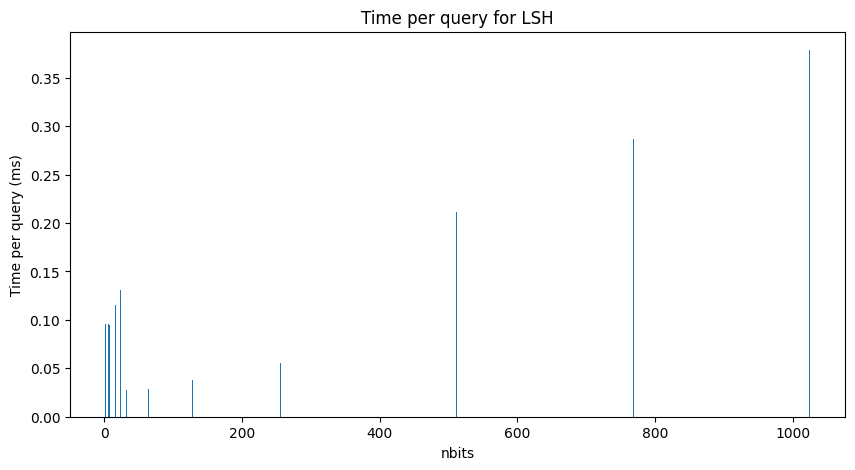

In [292]:
# plot results
# time per query bar chart
plt.figure(figsize=(10,5))
plt.bar(categories_LSH, SPQ_LSH, width=1.5, capsize=5)
plt.xlabel('nbits')
plt.ylabel('Time per query (ms)')
plt.title('Time per query for LSH')
plt.show()

Generally increasing. Not sure about the dip at 32. Possibly related to the number of vectors in a bucket.

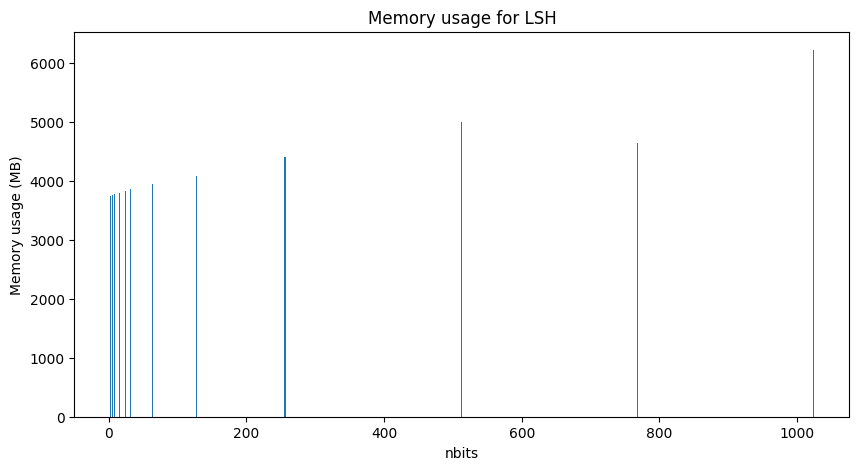

In [293]:
# memory usage bar chart
plt.figure(figsize=(10,5))
plt.bar(categories_LSH, memory_LSH, width=1.5, capsize=5)
plt.xlabel('nbits')
plt.ylabel('Memory usage (MB)')
plt.title('Memory usage for LSH')
plt.show()

Generally increasing. Not sure why the memory usage dips at 768.

[2.10000e-05 1.29000e-04 2.95000e-04 4.74800e-03 1.61870e-02 2.90350e-02
 9.65980e-02 2.15974e-01 3.53582e-01 4.92327e-01 5.69969e-01 6.19148e-01]


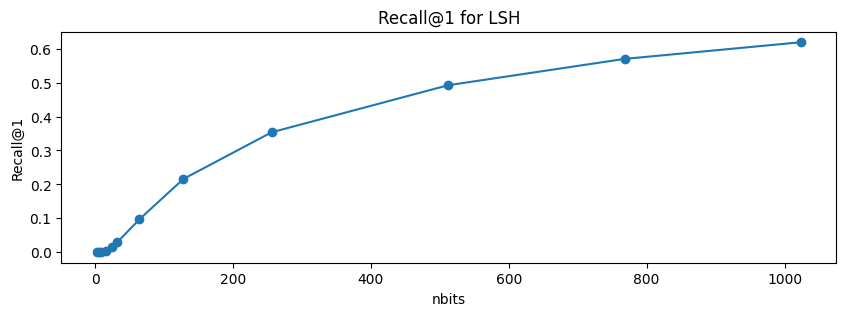

In [294]:
# recall smooth line chart
plt.figure(figsize=(10,3))
print(recall_LSH)
plt.plot(categories_LSH, recall_LSH, marker='o')
plt.xlabel('nbits')
plt.ylabel('Recall@1')
plt.title('Recall@1 for LSH')
plt.show()

Generally increasing. The more the nbits, the higer the accuracy.

#### **Individual analysis: PQ** ####
PQ stands for Product Quantization. It is a method that partitions the input vectors into subvectors and quantizes each subvectors of the input vectors into a small number of bits. The results of PQ with different parameters are shown below:

Shape of result array: (1, 6, 3, 6)
Shape of average result array: (6, 3, 6)
m: [16, 32, 64, 96]
nbits: [6, 8, 10]


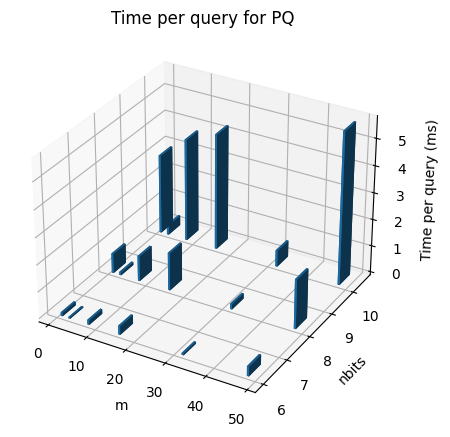

In [295]:
# read PQ results
PQ_results = '/home/ypx/faissTesting/benchmark/results/PQ_10M_96_10k_100.h5'
PQ_results = io.load_results(PQ_results)
print('Shape of result array:', PQ_results.shape)

# calculate average
avg_PQ = np.mean(PQ_results, axis=0)
std_PQ = np.std(PQ_results, axis=0)
print('Shape of average result array:', avg_PQ.shape)

index_dict = bm.INDPARAM['PQ']
param1 = index_dict['params'][0]
categories1_PQ = index_dict[param1]
print(str(param1) + ':', categories)
param2 = index_dict['params'][1]
categories2_PQ = index_dict[param2]
print(str(param2) + ':', categories2)

# get results
SPQ_PQ = avg_PQ[:,:,3]*1000
memory_PQ = avg_PQ[:,:,4]
recall_PQ = avg_PQ[:,:,5]

# create 3D bar chart for each result
# SPQ
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
m, nbits = np.meshgrid(categories1_PQ, categories2_PQ)
m = m.flatten()
nbits = nbits.flatten()
SPQ_PQ = SPQ_PQ.flatten()

dx = 0.5
dy = 0.5
dz = SPQ_PQ
ax.bar3d(m, nbits, np.zeros(len(SPQ_PQ)), dx, dy, dz)

ax.set_xlabel(param1)
ax.set_ylabel(param2)
ax.set_zlabel('Time per query (ms)')
ax.set_title('Time per query for PQ')
plt.show()



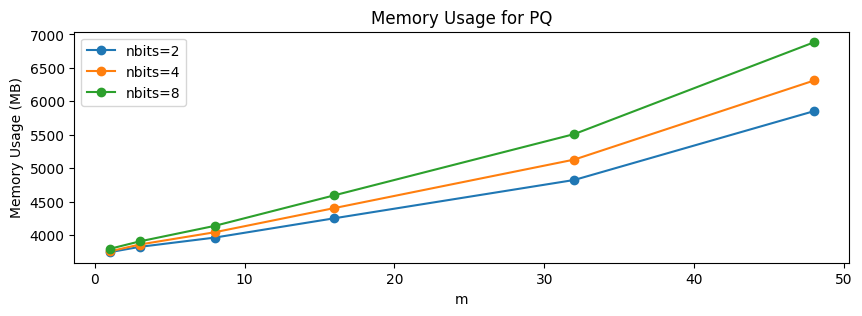

In [296]:
# memory
# get memory for each nbits
mem_0 = memory_PQ[:, 0]
mem_1 = memory_PQ[:, 1]
mem_2 = memory_PQ[:, 2]

# plot them together
plt.figure(figsize=(10,3))
plt.plot(categories1_PQ, mem_0, marker='o', label='nbits=2')
plt.plot(categories1_PQ, mem_1, marker='o', label='nbits=4')
plt.plot(categories1_PQ, mem_2, marker='o', label='nbits=8')
plt.xlabel(param1)
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage for PQ')
plt.legend()
plt.show()

(6, 3)


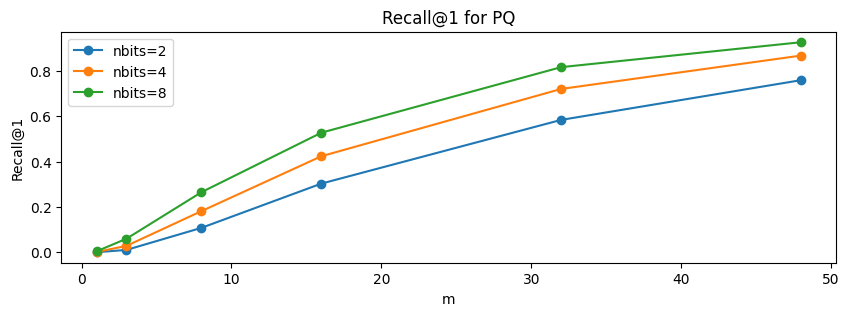

In [297]:
# recall
# I want to show them as lines in a 2D plot
# where the x axis is the m value
# and the y axis is the recall value
# different nbits are different lines
# so I need to create a 2D array for each nbits
# then plot them together
print(recall_PQ.shape)

# get recall for each nbits
recall_0 = recall_PQ[:, 0]
recall_1 = recall_PQ[:, 1]
recall_2 = recall_PQ[:, 2]

# plot them together
plt.figure(figsize=(10,3))
plt.plot(categories1_PQ, recall_0, marker='o', label='nbits=2')
plt.plot(categories1_PQ, recall_1, marker='o', label='nbits=4')
plt.plot(categories1_PQ, recall_2, marker='o', label='nbits=8')
plt.xlabel(param1)
plt.ylabel('Recall@1')
plt.title('Recall@1 for PQ')
plt.legend()
plt.show()


#### **Individual analysis: HSNW** ####
HNSW stands for Hierarchical Navigable Small World. It is a graph-based index that builds a graph on the dataset and uses the graph to guide the search. The results of HNSW with different parameters are shown below:

Shape of result array: (2, 1, 4, 6)
Shape of average result array: (1, 11, 6)
HNSW training time: [3.79085541e-05 1.71661377e-05 1.71661377e-05 1.64508820e-05
 1.74045563e-05 1.71661377e-05 1.66893005e-05 1.78813934e-05
 1.62124634e-05 1.66893005e-05 1.64508820e-05]
HNSW adding time: [ 1.17458916  1.51856089  1.21252823  1.52712035  1.99757123  2.28452039
  3.91258383  7.02542329 12.80491567 24.42558265 87.16842079]
HNSW total search time: [ 95.34751987  95.44824815  95.12270641 115.59598136 130.91120005
  27.56626987  28.81799912  38.08640766  55.33311343 211.63541055
 378.49284768]
M: [16, 32, 64, 96]


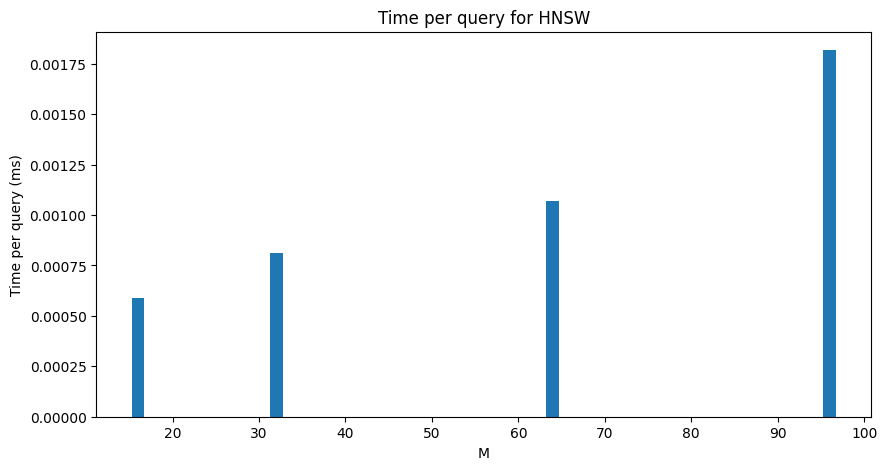

In [298]:
# read HNSW results
HNSW_results = '/home/ypx/faissTesting/benchmark/results/HNSWFlat_10M_96_10k_100.h5'
HNSW_results = io.load_results(HNSW_results)
print('Shape of result array:', HNSW_results.shape)

# calculate average
avg_HNSW = np.mean(HNSW_results, axis=0)
std_HNSW = np.std(HNSW_results, axis=0)
print('Shape of average result array:', avg.shape)

print('HNSW training time:', avg[0,:,0])
print('HNSW adding time:', avg[0,:,1])
print('HNSW total search time:', avg[0,:,2])

index_dict = bm.INDPARAM['HNSWFlat']
param1 = index_dict['params'][0]
categories_HNSW = index_dict[param1]
print(str(param1) + ':', categories_HNSW)

# get results
SPQ_HNSW = avg_HNSW[0,:,3]*1000
memory_HNSW = avg_HNSW[0,:,4]
recall_HNSW = avg_HNSW[0,:,5]

# create bar chart for each result
# SPQ
plt.figure(figsize=(10,5))
plt.bar(categories_HNSW, SPQ_HNSW, width=1.5, capsize=5)
plt.xlabel(param1)
plt.ylabel('Time per query (ms)')
plt.title('Time per query for HNSW')
plt.show()

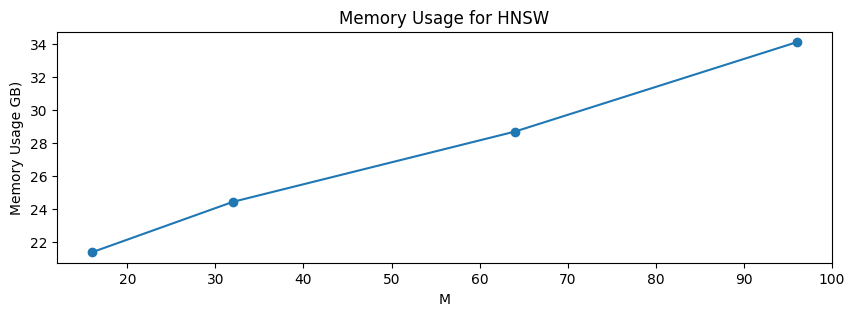

In [299]:
# memory ploted as lines
plt.figure(figsize=(10,3))
plt.plot(categories_HNSW, memory_HNSW/1024, marker='o')
plt.xlabel(param1)
plt.ylabel('Memory Usage GB)')
plt.title('Memory Usage for HNSW')
plt.show()


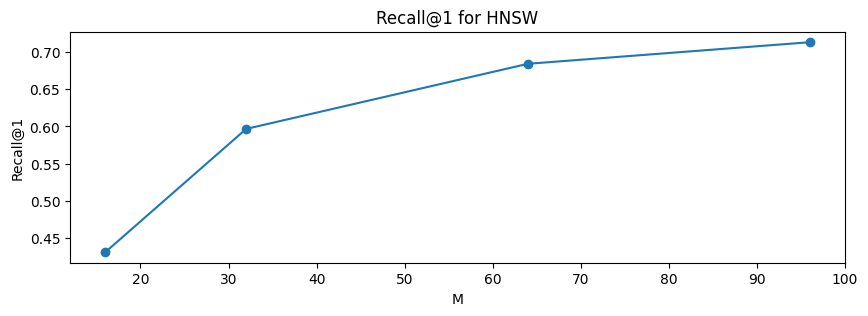

In [300]:
# recall@1 in ploted lines
plt.figure(figsize=(10,3))
plt.plot(categories_HNSW, recall_HNSW, marker='o')
plt.xlabel(param1)
plt.ylabel('Recall@1')
plt.title('Recall@1 for HNSW')
plt.show()

#### **Horizontal Comparison** ####
In this section, we compare the same result (e.g. search time/recall) of different indexes.

[ 1  3  8 16 32 48  1  3  8 16 32 48  1  3  8 16 32 48]
[ 6  6  6  6  6  6  8  8  8  8  8  8 10 10 10 10 10 10]
[0.35679894 0.28680484 0.37849285 0.94265458 0.61263674 0.00106953
 0.00181741]
[1.        0.569969  0.619148  0.265321  0.868416  0.6841925 0.71315  ]
['FlatL2 (baseline)' 'LSH\nnbits=768' 'LSH\nnbits=1024' 'PQ\nm=8\nnbits=8'
 'PQ\nm=32\nnbits=10' 'HNSW\nM=64' 'HNSW\nM=96']


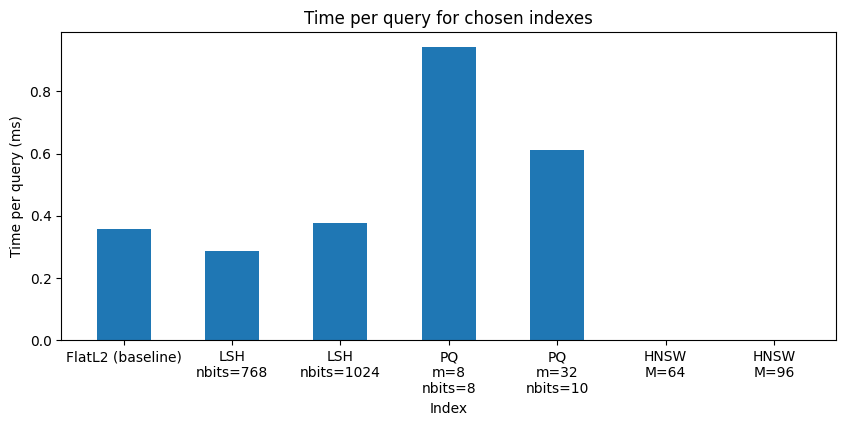

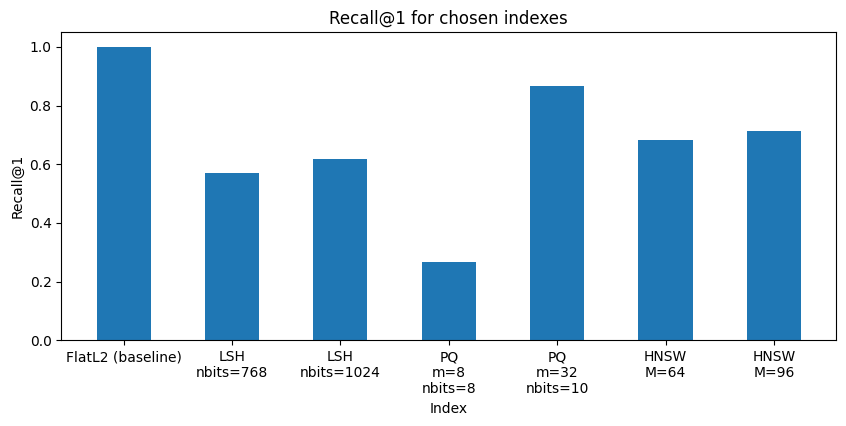

In [301]:
# Choose the SPQ for all indexes with some parameters in a list

# FlatL2_chosen:
SPQ_FLATL2_chosen = SPQ_FLATL2
recall_FLATL2_chosen = recall_FLATL2
catagories_FLATL2_chosen = ["FlatL2 (baseline)"]

# LSH_chosen: nbits = 768, 1025 (index: 10, 11)
SPQ_LSH_chosen = SPQ_LSH[10:12]
recall_LSH_chosen = recall_LSH[10:12]
catagories_LSH_chosen = ["LSH\nnbits=768", "LSH\nnbits=1024"]

# PQ_chosen: 
# (m, nbits) = (8, 8), (32, 10) (index: 8, 16)
# print(SPQ_PQ.shape)
print(m)
print(nbits)
SPQ_PQ_flat = SPQ_PQ.flatten()
recall_PQ_flat = recall_PQ.flatten()
SPQ_PQ_chosen = SPQ_PQ_flat[[8, 16]]
recall_PQ_chosen = recall_PQ_flat[[8, 16]]
catagories_PQ_chosen = ["PQ\nm=8\nnbits=8", "PQ\nm=32\nnbits=10"]

# HNSW_chosen: 
# M = 64, 96 (index: 2, 3)
SPQ_HNSW_chosen = SPQ_HNSW[2:4]
recall_HNSW_chosen = recall_HNSW[2:4]
catagories_HNSW_chosen = ["HNSW\nM=64", "HNSW\nM=96"]

# plot SPQ and recall side by side for all indexes and all parameters in a bar chart

# make aggregate lists
aggregate_SPQ = np.append(np.append(SPQ_FLATL2_chosen, SPQ_LSH_chosen), np.append(SPQ_PQ_chosen, SPQ_HNSW_chosen))
aggregate_recall = np.append(np.append(recall_FLATL2_chosen, recall_LSH_chosen), np.append(recall_PQ_chosen, recall_HNSW_chosen))
aggregate_categories = np.append(np.append(catagories_FLATL2_chosen, catagories_LSH_chosen), np.append(catagories_PQ_chosen, catagories_HNSW_chosen))

print(aggregate_SPQ)
print(aggregate_recall)
print(aggregate_categories)

# SPQ
plt.figure(figsize=(10,4))
plt.bar(list(aggregate_categories), list(aggregate_SPQ), width=0.5, capsize=5)
plt.xlabel('Index')
plt.ylabel('Time per query (ms)')
plt.title('Time per query for chosen indexes')
plt.show()

# recall@1
plt.figure(figsize=(10,4))
plt.bar(aggregate_categories, aggregate_recall, width=.5, capsize=5)
plt.xlabel('Index')
plt.ylabel('Recall@1')
plt.title('Recall@1 for chosen indexes')
plt.show()

